# Why study GANs ?
<a href=http://www.iangoodfellow.com/slides/2016-12-04-NIPS.pdf>Ian Goodfellow - NIPS 2016</a>

# Deep Convolutional GAN - DCGAN
## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


## Input dimensions

In [2]:
img_rows = 28
img_cols = img_rows
channels = 1

img_shape = (img_rows, img_cols, channels)
z_dim = 100

## Generator

In [3]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    
    model.add(Activation('tanh'))
    
    return model

## Discriminator

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

## Build and compile the DGAN

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

In [6]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the generator
generator = build_generator(z_dim)

discriminator.trainable = False

# Build and compile the gan
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train the DGAN

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    # Rescale pixels from [0-255] to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # Labels for real and fake images
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # Get a random sample from training dataset
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        # Create the random input to train the discriminato
        z = np.random.normal(0, 1, (batch_size, z_dim))
        # and passes to the generator
        gen_imgs = generator.predict(z)
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Create new random input for the generator
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        # Train the generator
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print(f"{iteration+1} [D loss: {d_loss}, acc: {100.0 * accuracy}%] [G loss]: {g_loss}")
            sample_images(generator)

## Display images

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    # Random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))
    
    gen_imgs = generator.predict(z)
    
    # Rescale values to 0, 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_cols,
                           figsize=(4, 4),
                           sharey=True,
                           sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Run the model

In [9]:
iterations = 20000
batch_size = 128
sample_interval = 1000

/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.013456806540489197, acc: 100.0%] [G loss]: 3.835782527923584
2000 [D loss: 0.10795503854751587, acc: 98.828125%] [G loss]: 4.650457382202148
3000 [D loss: 0.057191379368305206, acc: 99.609375%] [G loss]: 5.253856658935547
4000 [D loss: 0.051006413996219635, acc: 99.609375%] [G loss]: 4.673734664916992
5000 [D loss: 0.0874507799744606, acc: 99.21875%] [G loss]: 4.705301761627197
6000 [D loss: 0.15041477978229523, acc: 96.484375%] [G loss]: 3.312182903289795
7000 [D loss: 0.05805707722902298, acc: 99.21875%] [G loss]: 3.454935073852539
8000 [D loss: 0.03884257376194, acc: 99.609375%] [G loss]: 3.7171897888183594
9000 [D loss: 0.026868190616369247, acc: 100.0%] [G loss]: 4.377735137939453
10000 [D loss: 0.05301697924733162, acc: 99.21875%] [G loss]: 4.23630952835083
11000 [D loss: 0.02040873095393181, acc: 100.0%] [G loss]: 1.474320411682129
12000 [D loss: 0.009967717342078686, acc: 100.0%] [G loss]: 9.474315643310547
13000 [D loss: 0.021020762622356415, acc: 100.0%] [G lo

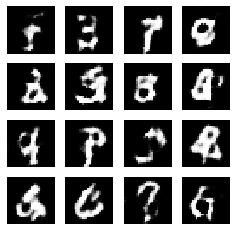

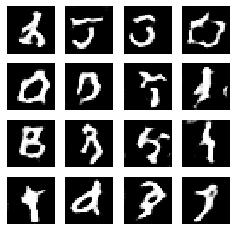

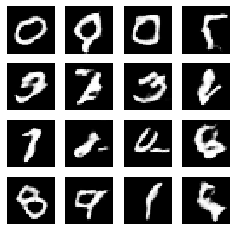

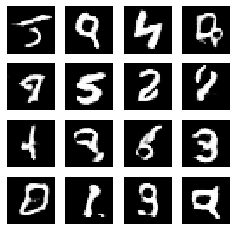

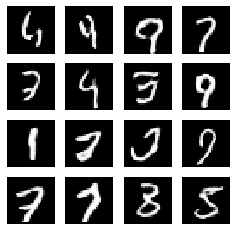

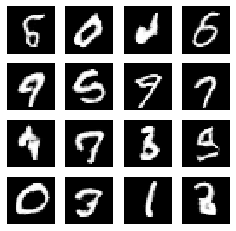

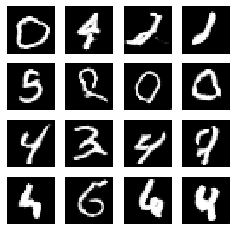

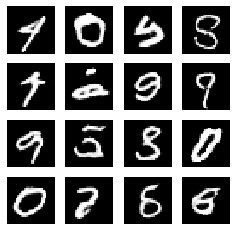

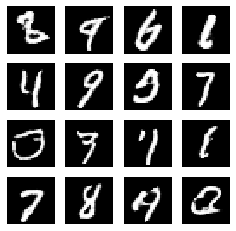

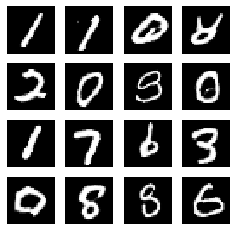

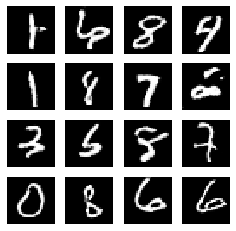

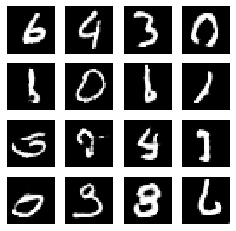

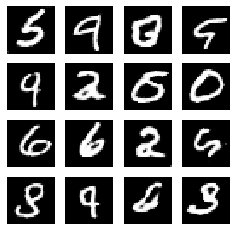

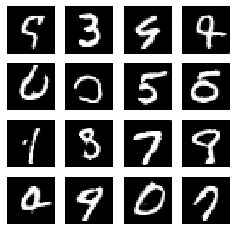

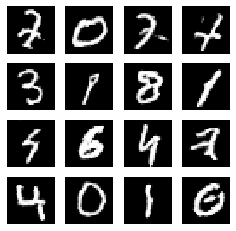

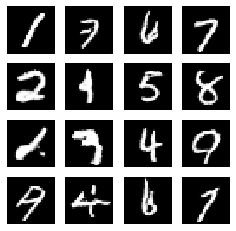

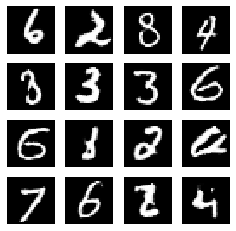

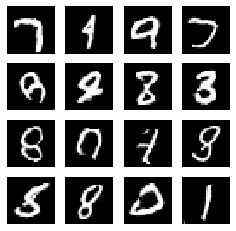

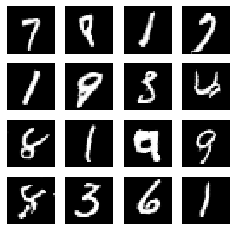

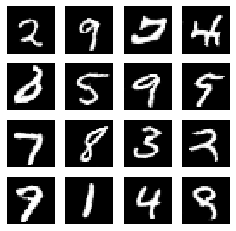

In [10]:
train(iterations, batch_size, sample_interval)

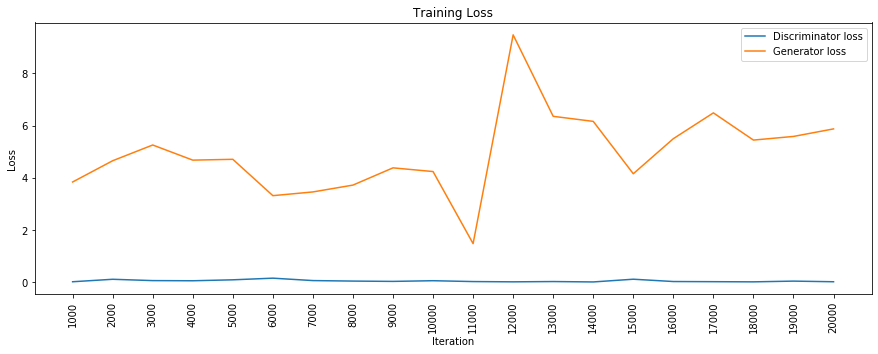

In [11]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

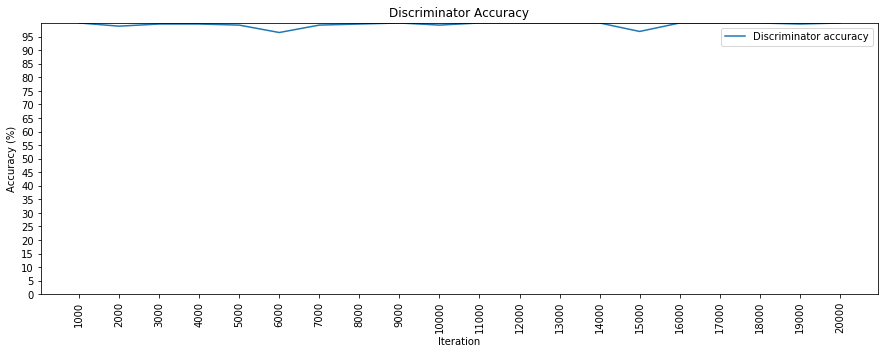

In [12]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()